<a href="https://colab.research.google.com/github/as791/stAdv-PyTorch/blob/main/StAdv_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms,datasets
from scipy import optimize 

##Train Model 

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 32, 3, 1)
    self.conv3= nn.Conv2d(32, 64, 3, 1)
    self.conv4= nn.Conv2d(64, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(1024, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = self.conv1(x)   
    x = F.relu(x)
    x = self.conv2(x)   
    x = F.relu(x)
    x = F.max_pool2d(x, 2)  
    x = self.conv3(x)       
    x = F.relu(x)
    x = self.conv4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)  
    x = torch.flatten(x,1)  
    x = self.fc1(x)         
    x = F.relu(x)
    x = self.dropout1(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)        
    return x

def fit(model,device,train_loader,val_loader,optimizer,criterion,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  train_acc,val_acc=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    acc_per_epoch,val_acc_per_epoch,total,val_total=0,0,0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        inputs,labels  = data[0].to(device),data[1].to(device)
        outputs = model(inputs)
        #preding classes of one batch
        preds = torch.max(outputs,1)[1]
        #calculating loss on the output of one batch
        loss = criterion(outputs,labels)
        if phase == 'train':
          acc_per_epoch+=(labels==preds).sum().item()
          total+= labels.size(0)
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_acc_per_epoch+=(labels==preds).sum().item()
          val_total+=labels.size(0)
          val_loss_per_epoch+=loss.item()
    print("Epoch: {} Loss: {:0.6f} Acc: {:0.6f} Val_Loss: {:0.6f} Val_Acc: {:0.6f}".format(epoch+1,loss_per_epoch/len(train_loader),acc_per_epoch/total,val_loss_per_epoch/len(val_loader),val_acc_per_epoch/val_total))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
    train_acc.append(acc_per_epoch/total)
    val_acc.append(val_acc_per_epoch/val_total)
  return train_loss,val_loss,train_acc,val_acc

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 32, 24, 24]           9,248
            Conv2d-3           [-1, 64, 10, 10]          18,496
            Conv2d-4             [-1, 64, 8, 8]          36,928
            Linear-5                  [-1, 200]         205,000
         Dropout2d-6                  [-1, 200]               0
            Linear-7                  [-1, 200]          40,200
            Linear-8                   [-1, 10]           2,010
Total params: 312,202
Trainable params: 312,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.39
Params size (MB): 1.19
Estimated Total Size (MB): 1.58
----------------------------------------------------------------
Fitting the model...
Epoch: 1 Loss: 1.4

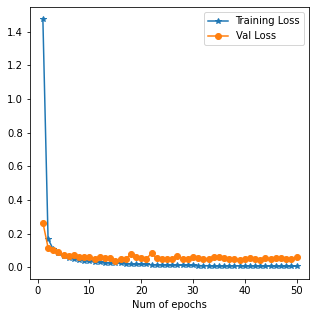

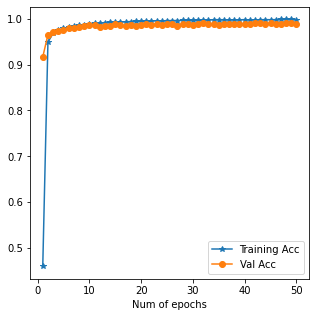

In [ ]:
if __name__=='__main__':
  np.random.seed(42)
  torch.manual_seed(42)

  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
  dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
  train_set, val_set = torch.utils.data.random_split(dataset, [55000, 5000])
  train_loader = torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set,batch_size=128,shuffle=True)
  
  use_cuda=True
  device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

  model = Net().to(device)
  summary(model,(1,28,28))

  optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-6)
  criterion = nn.CrossEntropyLoss()

  train_loss,val_loss,train_acc,val_acc=fit(model,device,train_loader,val_loader,optimizer,criterion,50)

  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,51), train_loss, "*-",label="Training Loss")
  plt.plot(np.arange(1,51), val_loss,"o-",label="Val Loss")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  # plt.savefig('loss_event.png')

  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,51), train_acc, "*-",label="Training Acc")
  plt.plot(np.arange(1,51), val_acc,"o-",label="Val Acc")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  # plt.savefig('accuracy_event.png')

  torch.save(model.state_dict(),'./model.pt')

##stAdv Attack 

In [ ]:
#https://github.com/rakutentech/stAdv - refered code
def flow_st(images,flows):
  images_shape = images.size()
  flows_shape = flows.size()
  batch_size = images_shape[0]
  H = images_shape[2]
  W = images_shape[3]
  basegrid = torch.stack(torch.meshgrid(torch.arange(0,H), torch.arange(0,W))) #(2,H,W)
  sampling_grid = basegrid.unsqueeze(0).type(torch.float32).cuda() + flows.cuda()
  sampling_grid_x = torch.clamp(sampling_grid[:,1],0.0,W-1.0).type(torch.float32)
  sampling_grid_y = torch.clamp(sampling_grid[:,0],0.0,H-1.0).type(torch.float32)

  x0 = torch.floor(sampling_grid_x).type(torch.int64)
  x1 = x0 + 1
  y0 = torch.floor(sampling_grid_y).type(torch.int64)
  y1 = y0 + 1

  x0 = torch.clamp(x0, 0, W - 2)
  x1 = torch.clamp(x1, 0, W - 1)
  y0 = torch.clamp(y0, 0, H - 2)
  y1 = torch.clamp(y1, 0, H - 1)
  
  Ia = images[:,:,y0[0,:,:], x0[0,:,:]]
  Ib = images[:,:,y1[0,:,:], x0[0,:,:]]
  Ic = images[:,:,y0[0,:,:], x1[0,:,:]]
  Id = images[:,:,y1[0,:,:], x1[0,:,:]]

  x0 = x0.type(torch.float32)
  x1 = x1.type(torch.float32)
  y0 = y0.type(torch.float32)
  y1 = y1.type(torch.float32)
  
  wa = (x1 - sampling_grid_x) * (y1 - sampling_grid_y)
  wb = (x1 - sampling_grid_x) * (sampling_grid_y - y0)
  wc = (sampling_grid_x - x0) * (y1 - sampling_grid_y)
  wd = (sampling_grid_x - x0) * (sampling_grid_y - y0)
  
  perturbed_image = wa.unsqueeze(0)*Ia+wb.unsqueeze(0)*Ib+wc.unsqueeze(0)*Ic+wd.unsqueeze(0)*Id

  return perturbed_image.type(torch.float32).cuda()

In [ ]:
def flow_loss(flows,padding_mode='constant', epsilon=1e-8):
  paddings = (1,1,1,1)
  padded_flows = F.pad(flows,paddings,mode=padding_mode,value=0)
  shifted_flows = [
    padded_flows[:, :, 2:, 2:],  # bottom right (+1,+1)
    padded_flows[:, :, 2:, :-2],  # bottom left (+1,-1)
    padded_flows[:, :, :-2, 2:],  # top right (-1,+1)
    padded_flows[:, :, :-2, :-2]  # top left (-1,-1)
  ]
  #||\Delta u^{(p)} - \Delta u^{(q)}||_2^2 + # ||\Delta v^{(p)} - \Delta v^{(q)}||_2^2 
  loss=0
  for shifted_flow in shifted_flows:
    loss += torch.sum(torch.square(flows[:, 1] - shifted_flow[:, 1]) + torch.square(flows[:, 0] - shifted_flow[:, 0]) + epsilon).cuda()
  return loss.type(torch.float32)

def adv_loss(logits,targets,confidence=0.0):
  confidence=torch.tensor(confidence).cuda()
  real = torch.sum(logits*targets,-1)
  other = torch.max((1-targets)*logits-(targets*10000),-1)[0]
  return torch.max(other-real,confidence)[0].type(torch.float32)

In [ ]:
def func(flows,input,target,model,const=0.05):
  input = torch.from_numpy(input).cuda()
  target = torch.from_numpy(target).cuda()
  flows = torch.from_numpy(flows).view((1,2,)+input.size()[2:]).cuda()
  flows.requires_grad=True
  pert_out = flow_st(input,flows)
  output = model(pert_out)
  L_flow = flow_loss(flows)
  L_adv = adv_loss(output,target)
  L_final = L_adv+const*L_flow
  model.zero_grad()
  L_final.backward()
  gradient = flows.grad.data.view(-1).detach().cpu().numpy()
  return L_final.item(),gradient

In [ ]:
def attack(input,target,model):
  init_flows = np.zeros((1,2,)+input.size()[2:]).reshape(-1)
  results = optimize.fmin_l_bfgs_b(func,init_flows,args=(input.cpu().numpy(),target.cpu().numpy(),model))
  if b'CONVERGENCE' in results[2]['task']:
    flows = torch.from_numpy(results[0]).view((1,2,)+input.size()[2:])
    pert_out = flow_st(input,flows)
  else:
    return None
  return pert_out

In [ ]:
if __name__=='__main__':
  np.random.seed(42)
  torch.manual_seed(42)

  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
  testset = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
  test_loader = torch.utils.data.DataLoader(testset,batch_size=1,shuffle=True)

  use_cuda=True
  device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
  model = Net().to(device) 
  model.load_state_dict(torch.load('./model.pt'))
  model.eval()

  adv=[]
  adv_label=[]
  correct_label=[]
  sample=100
  success=0
  for i,data in enumerate(test_loader):
    if i<sample:
      input,label = data[0].to(device),data[1].to(device)
      random_target = np.random.choice([num for num in range(10) if num != label.item()])
      target = torch.from_numpy(np.expand_dims(np.eye(10, dtype=np.float32)[random_target],0)).cuda()
      pert_out = attack(input,target,model)
      if pert_out!=None:
        output =  model(pert_out) 
        adv.append(pert_out.squeeze().detach().cpu().numpy())
        correct_label.append(label.item())
        adv_label.append(torch.argmax(output).item())
        if label.item()!=torch.argmax(output).item():
          success+=1
    else:
      break

Success Rate: 0.3800 


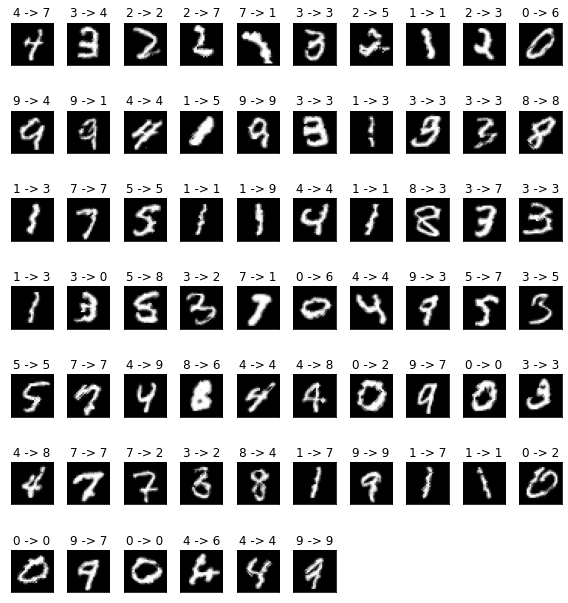

In [ ]:
print("Success Rate: {:.4f} ".format(success/sample))
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(adv)):
  cnt += 1
  plt.subplot(8,10,cnt)
  plt.xticks([], [])
  plt.yticks([], [])
  orig,adv_,ex = correct_label[i],adv_label[i],adv[i]
  plt.title("{} -> {}".format(orig, adv_))
  plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()